# Master thesis - Imbalanced learning and model interpretation in credit scoring

620146 Sinan Wang

# Table of Contents

    1. Load Data and artificial dataset construction
       1.1 Load data
       1.2 IR inspection
    2. Data clean and EDA
       2.1 Numerical feature clean and EDA
    3. Splitting data and Feature Engineering
       3.1 Split data
       3.2 Feature engineer
           3.2.1 Standardise numerical variables
    4. Obtain resampling data
    5. Model training
       5.1 Random forest
       5.2 Neural network
       5.3 Logit
           5.3.1 Logit training
           5.3.2 Apply resampling methods on Logit
       5.4 XGBoost
           5.4.1 XGBoost training
           5.4.2 Apply resampling methods on XGBoost
    6. XAI
       6.1 SHAP fearure importance
           6.1.1 Calculate SHAP feature importance
           6.1.2 SHAP rank correlation
           6.1.3 SHAP feature importance visualisation
       6.2 PFI
           6.2.1 Calculate PFI
           6.2.2 PFI rank correlation
           6.2.3 PFI feature importance visualisation

In [1]:
# Inspecting dataport libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import Input,layers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.io import arff
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

%load_ext autoreload
%autoreload 2

# 1. Load Data and artificial dataset construction

## 1.1 Load data

In [2]:
#read df
data = arff.loadarff('/Users/kelly/Desktop/code_final/data/ucip.arff')
ucip = pd.DataFrame(data[0])

ucip.rename(columns={'class': 'target'},
                inplace=True)

print(ucip.shape)
print(ucip.info())

(10503, 65)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10503 entries, 0 to 10502
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   10503 non-null  float64
 1   Attr2   10503 non-null  float64
 2   Attr3   10503 non-null  float64
 3   Attr4   10485 non-null  float64
 4   Attr5   10478 non-null  float64
 5   Attr6   10503 non-null  float64
 6   Attr7   10503 non-null  float64
 7   Attr8   10489 non-null  float64
 8   Attr9   10500 non-null  float64
 9   Attr10  10503 non-null  float64
 10  Attr11  10503 non-null  float64
 11  Attr12  10485 non-null  float64
 12  Attr13  10460 non-null  float64
 13  Attr14  10503 non-null  float64
 14  Attr15  10495 non-null  float64
 15  Attr16  10489 non-null  float64
 16  Attr17  10489 non-null  float64
 17  Attr18  10503 non-null  float64
 18  Attr19  10460 non-null  float64
 19  Attr20  10460 non-null  float64
 20  Attr21  9696 non-null   float64
 21  Attr22  10503 non-null 

## 1.2 IR inspection

In [3]:
ucip.target.replace({b'0':0, b'1':1}, inplace=True)
ucip.target.value_counts()

0    10008
1      495
Name: target, dtype: int64

In [4]:
IR_ori = round(len(ucip.loc[ucip['target'] == 0])/len(ucip.loc[ucip['target'] == 1]),2)
print('The imbalance ratio of the original data set is '+ str(IR_ori))

The imbalance ratio of the original data set is 20.22


<AxesSubplot:ylabel='target'>

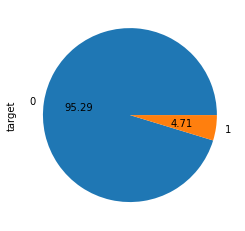

In [5]:
ucip.target.value_counts().plot.pie(autopct = "%.2f")

# 2. Data clean and EDA

## 2.1 Numerical feature clean and EDA

In [9]:
#numerical variables 
numvars = ['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8',
       'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15',
       'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22',
       'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29',
       'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36',
       'Attr37', 'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43',
       'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50',
       'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57',
       'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64']
ucip[numvars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10503 entries, 0 to 10502
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   10503 non-null  float64
 1   Attr2   10503 non-null  float64
 2   Attr3   10503 non-null  float64
 3   Attr4   10485 non-null  float64
 4   Attr5   10478 non-null  float64
 5   Attr6   10503 non-null  float64
 6   Attr7   10503 non-null  float64
 7   Attr8   10489 non-null  float64
 8   Attr9   10500 non-null  float64
 9   Attr10  10503 non-null  float64
 10  Attr11  10503 non-null  float64
 11  Attr12  10485 non-null  float64
 12  Attr13  10460 non-null  float64
 13  Attr14  10503 non-null  float64
 14  Attr15  10495 non-null  float64
 15  Attr16  10489 non-null  float64
 16  Attr17  10489 non-null  float64
 17  Attr18  10503 non-null  float64
 18  Attr19  10460 non-null  float64
 19  Attr20  10460 non-null  float64
 20  Attr21  9696 non-null   float64
 21  Attr22  10503 non-null  float64
 22

### Check the missing values

In [10]:
print(ucip[numvars].isnull().sum())

Attr1       0
Attr2       0
Attr3       0
Attr4      18
Attr5      25
         ... 
Attr60    592
Attr61     17
Attr62     43
Attr63     18
Attr64    228
Length: 64, dtype: int64


In [12]:
#exclude missing value more than 20%--Attr37
numvars = ['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8',
       'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15',
       'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22',
       'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29',
       'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36',
       'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43',
       'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50',
       'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57',
       'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64']

In [13]:
for col in numvars:  # loop over all numeric columns
    if ucip[col].isna().sum() > 0:                        
        m = ucip[col].median(skipna=True)                  
        ucip[col].fillna(m, inplace=True)                 

In [14]:
# check the missing values
print(ucip[numvars].isnull().sum() )

Attr1     0
Attr2     0
Attr3     0
Attr4     0
Attr5     0
         ..
Attr60    0
Attr61    0
Attr62    0
Attr63    0
Attr64    0
Length: 63, dtype: int64


### EDA

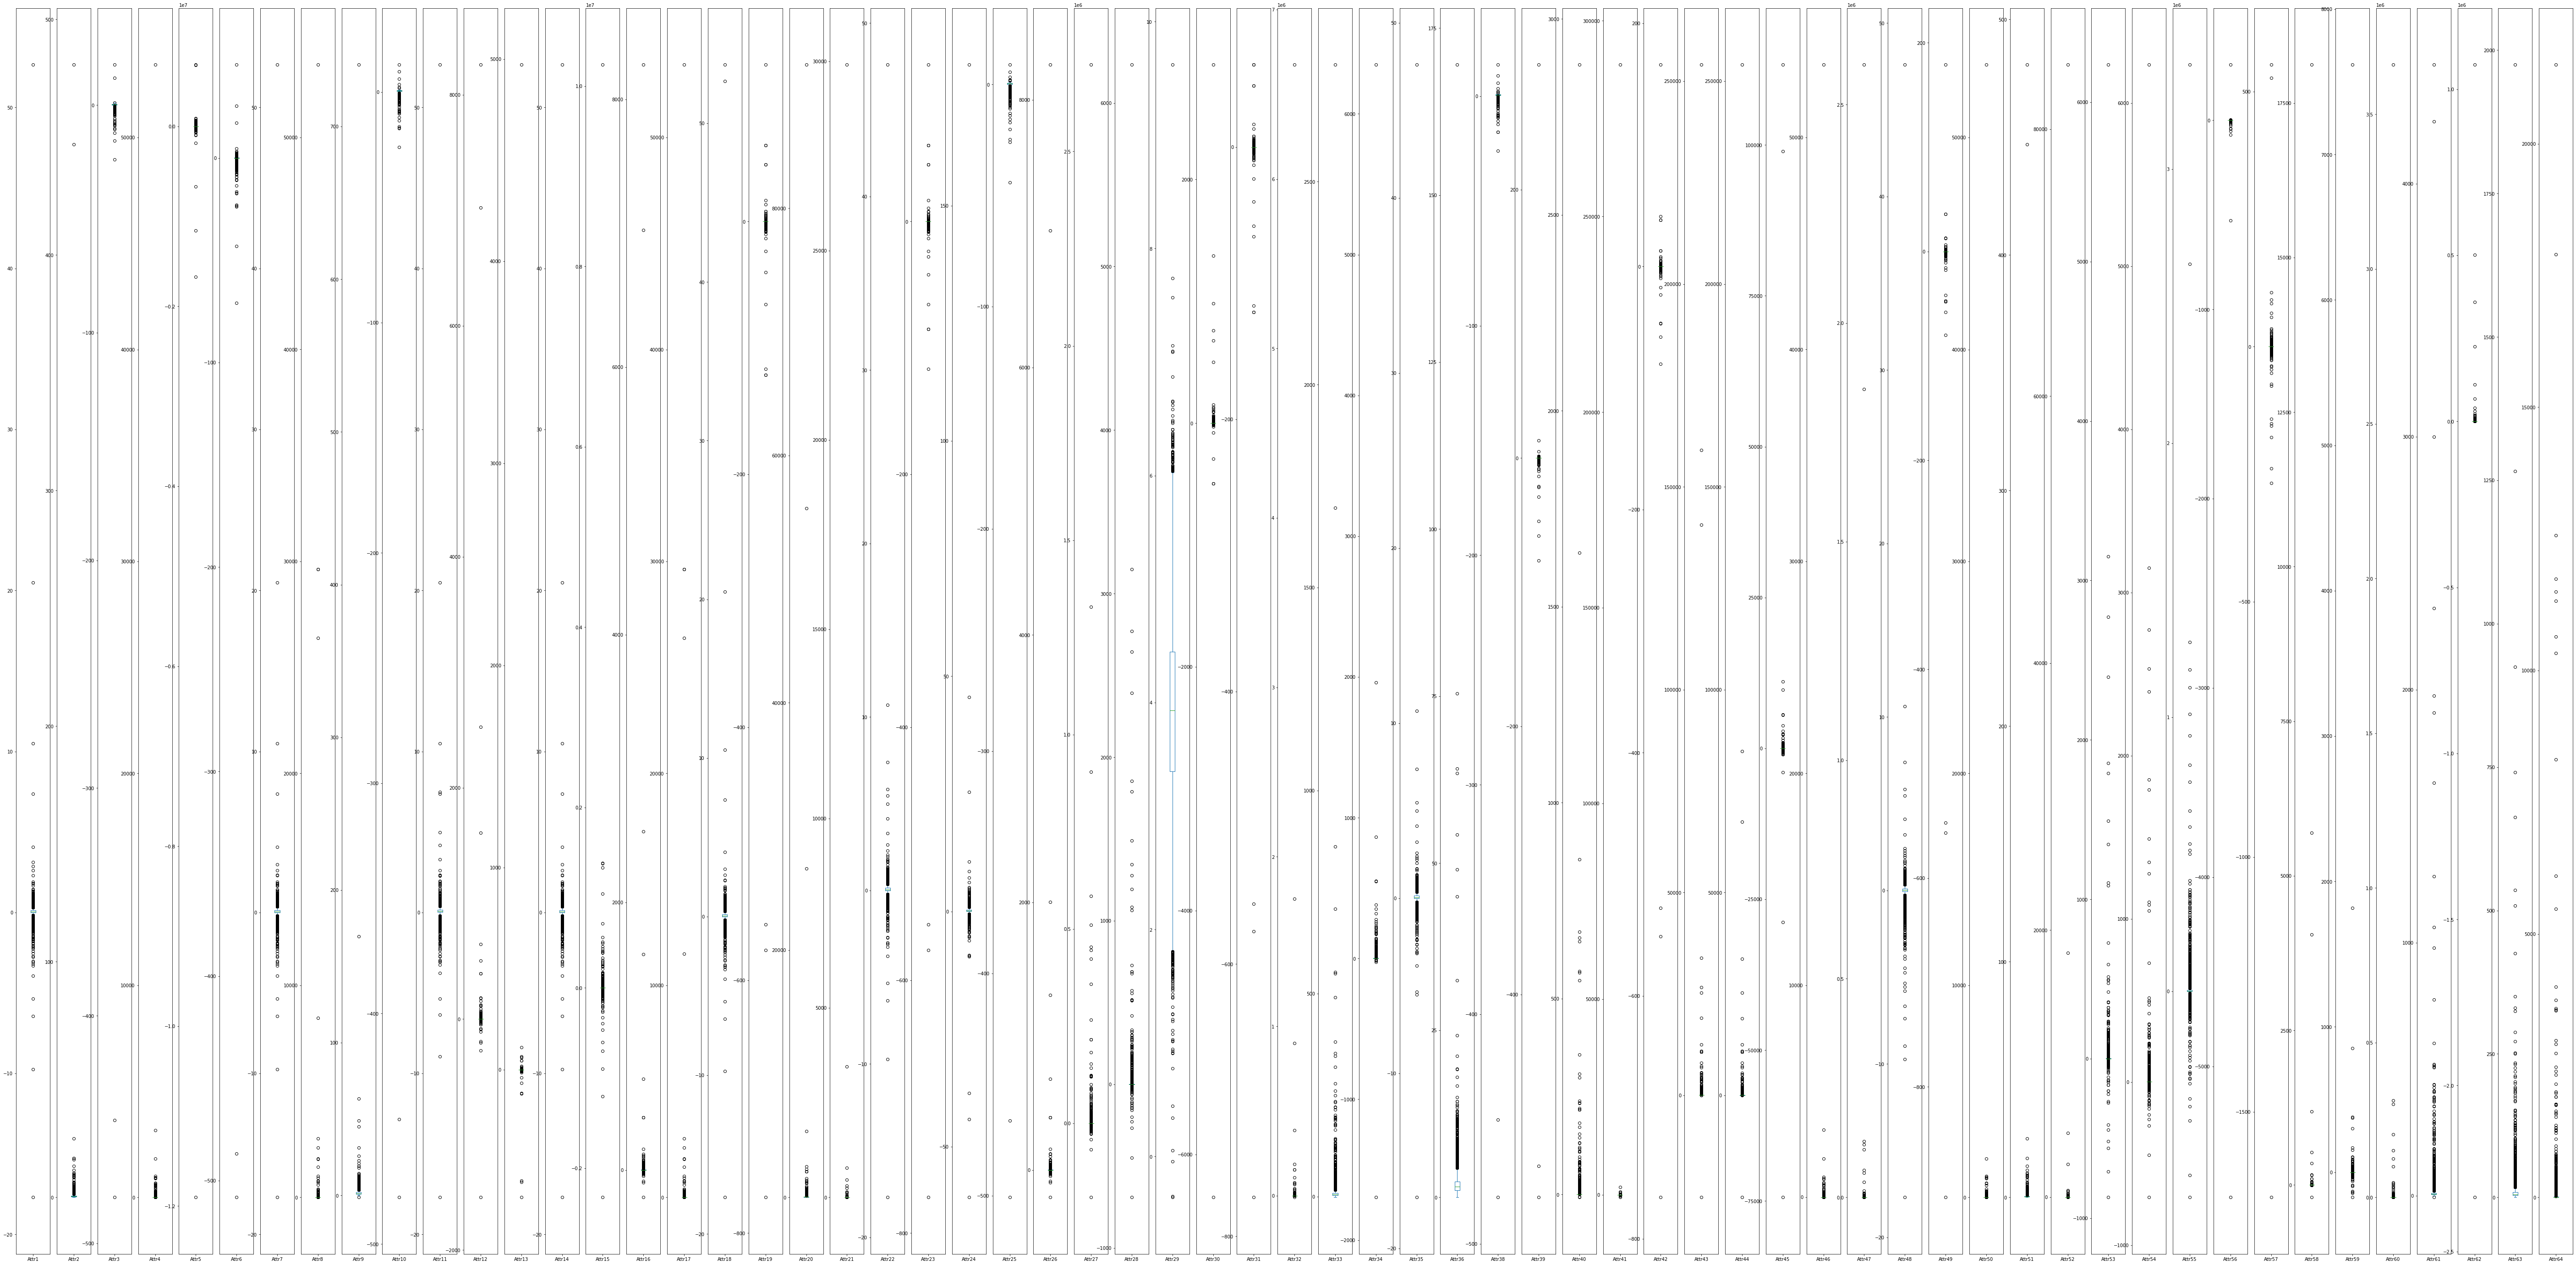

In [15]:
#check the distribution
plt.rcParams["figure.figsize"] = (100,50)
num_vars = ucip[numvars]
num_vars.plot(kind = 'box', subplots=True);

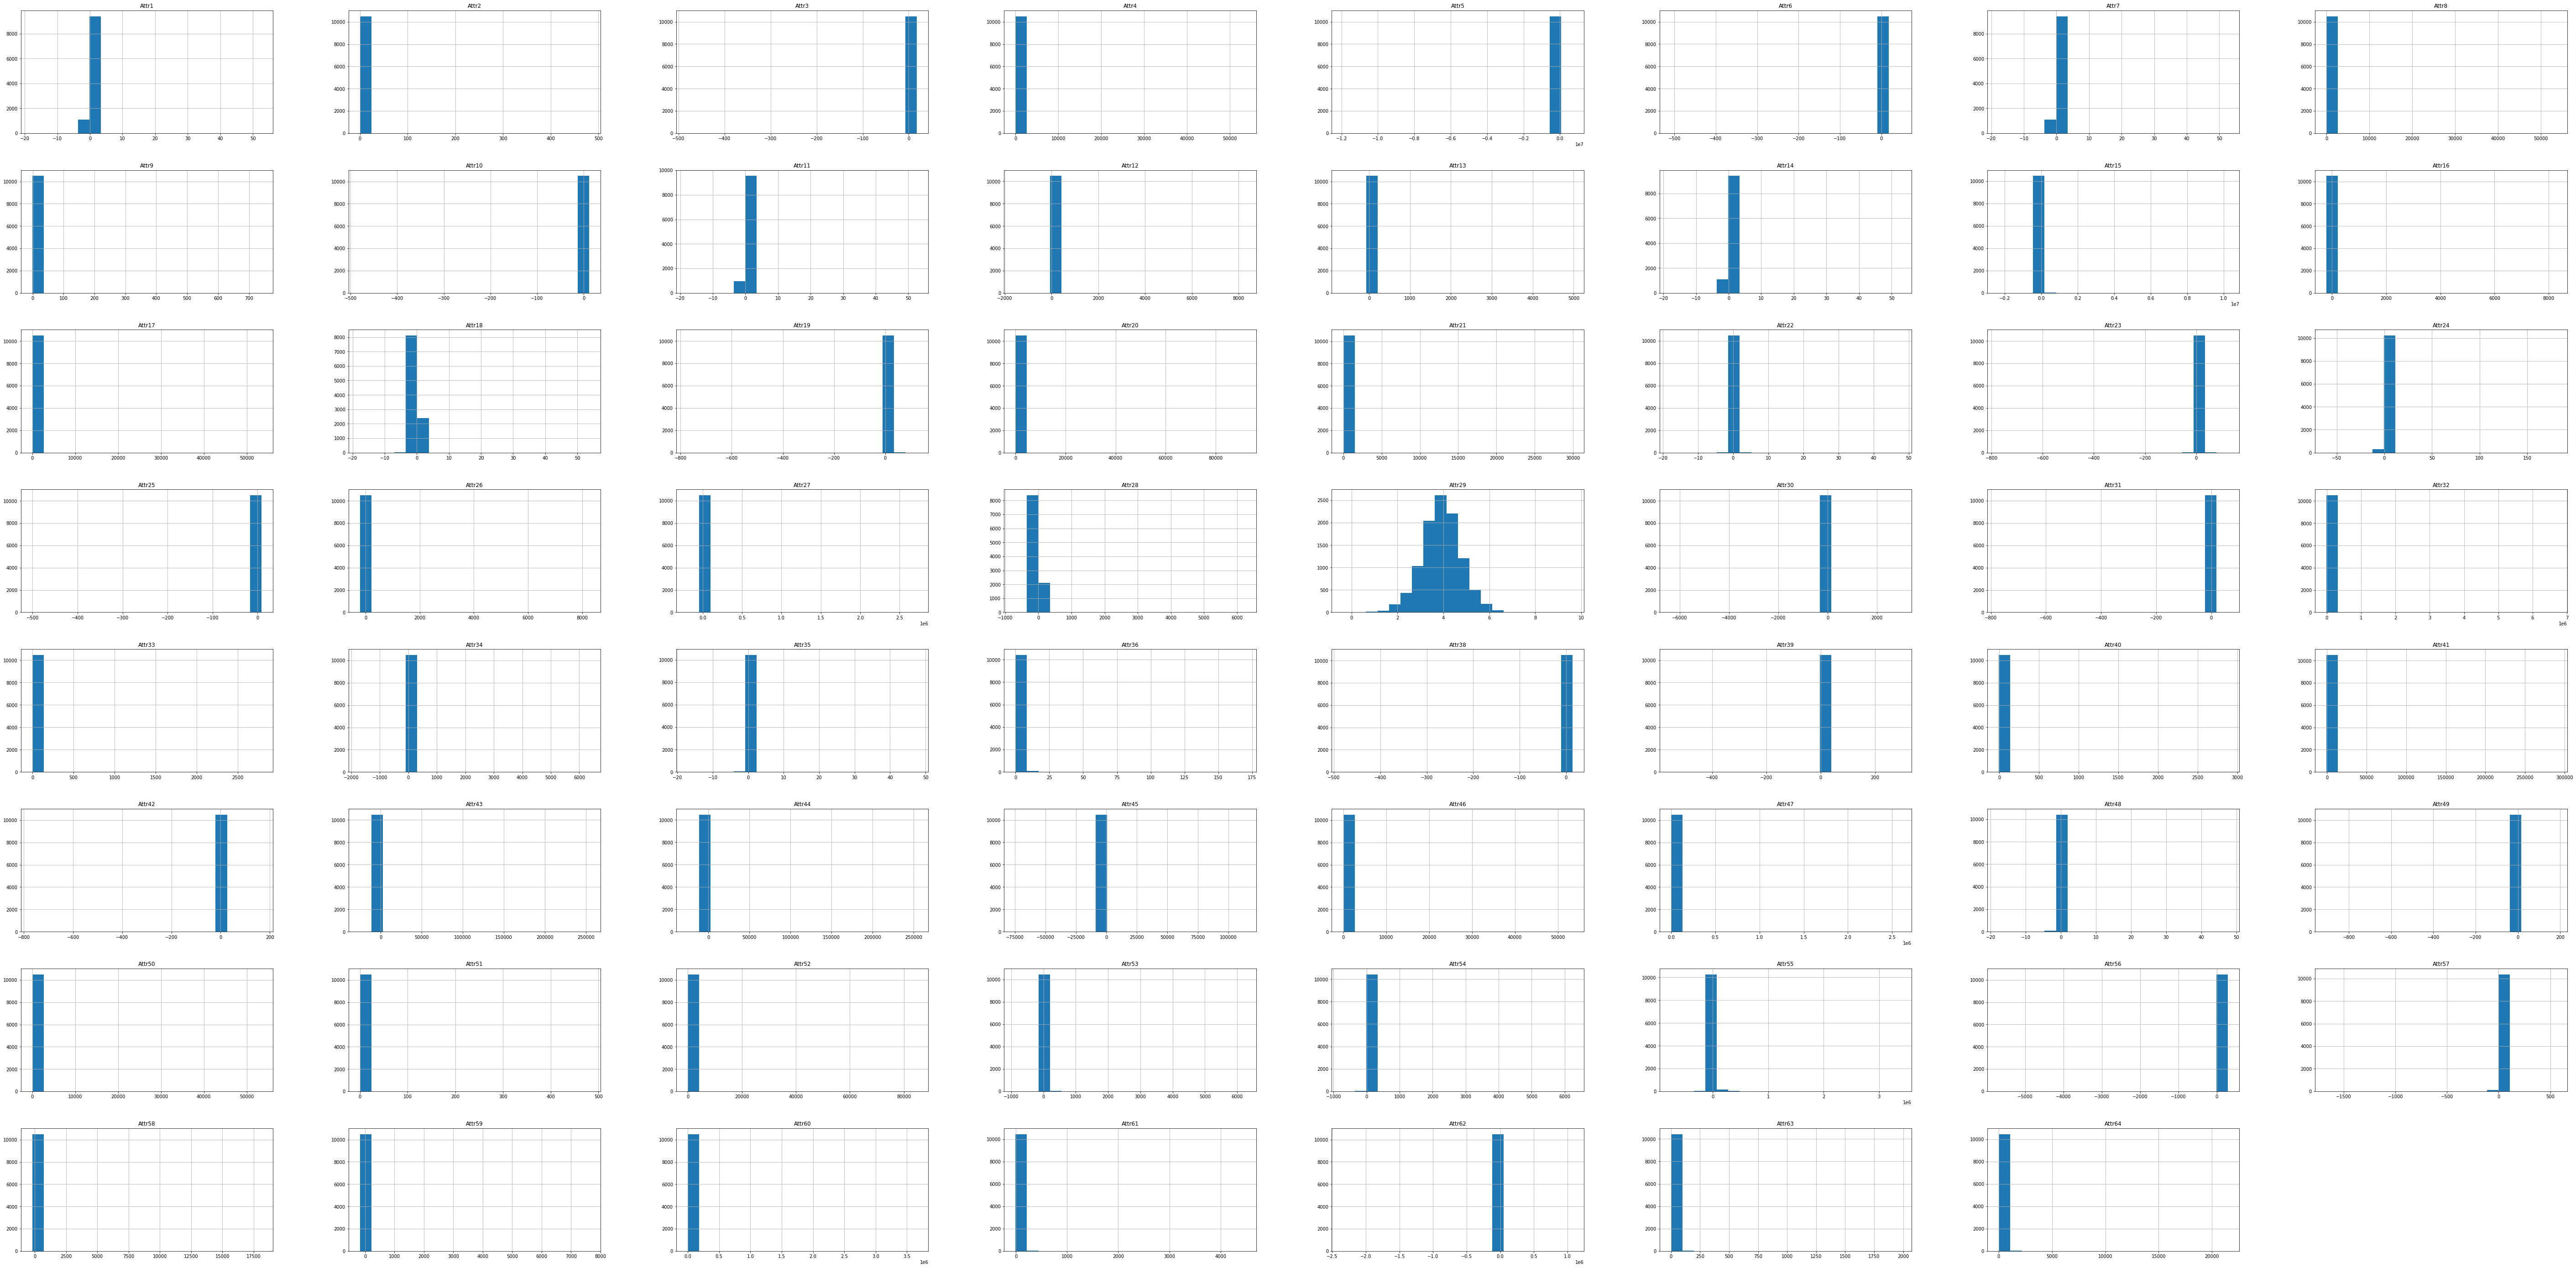

In [16]:
# check the distribution
ucip[numvars].hist(bins=20);

### Check the correlation

In [17]:
all_num = ['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8',
       'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15',
       'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22',
       'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29',
       'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36',
       'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43',
       'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50',
       'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57',
       'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64', 'target']

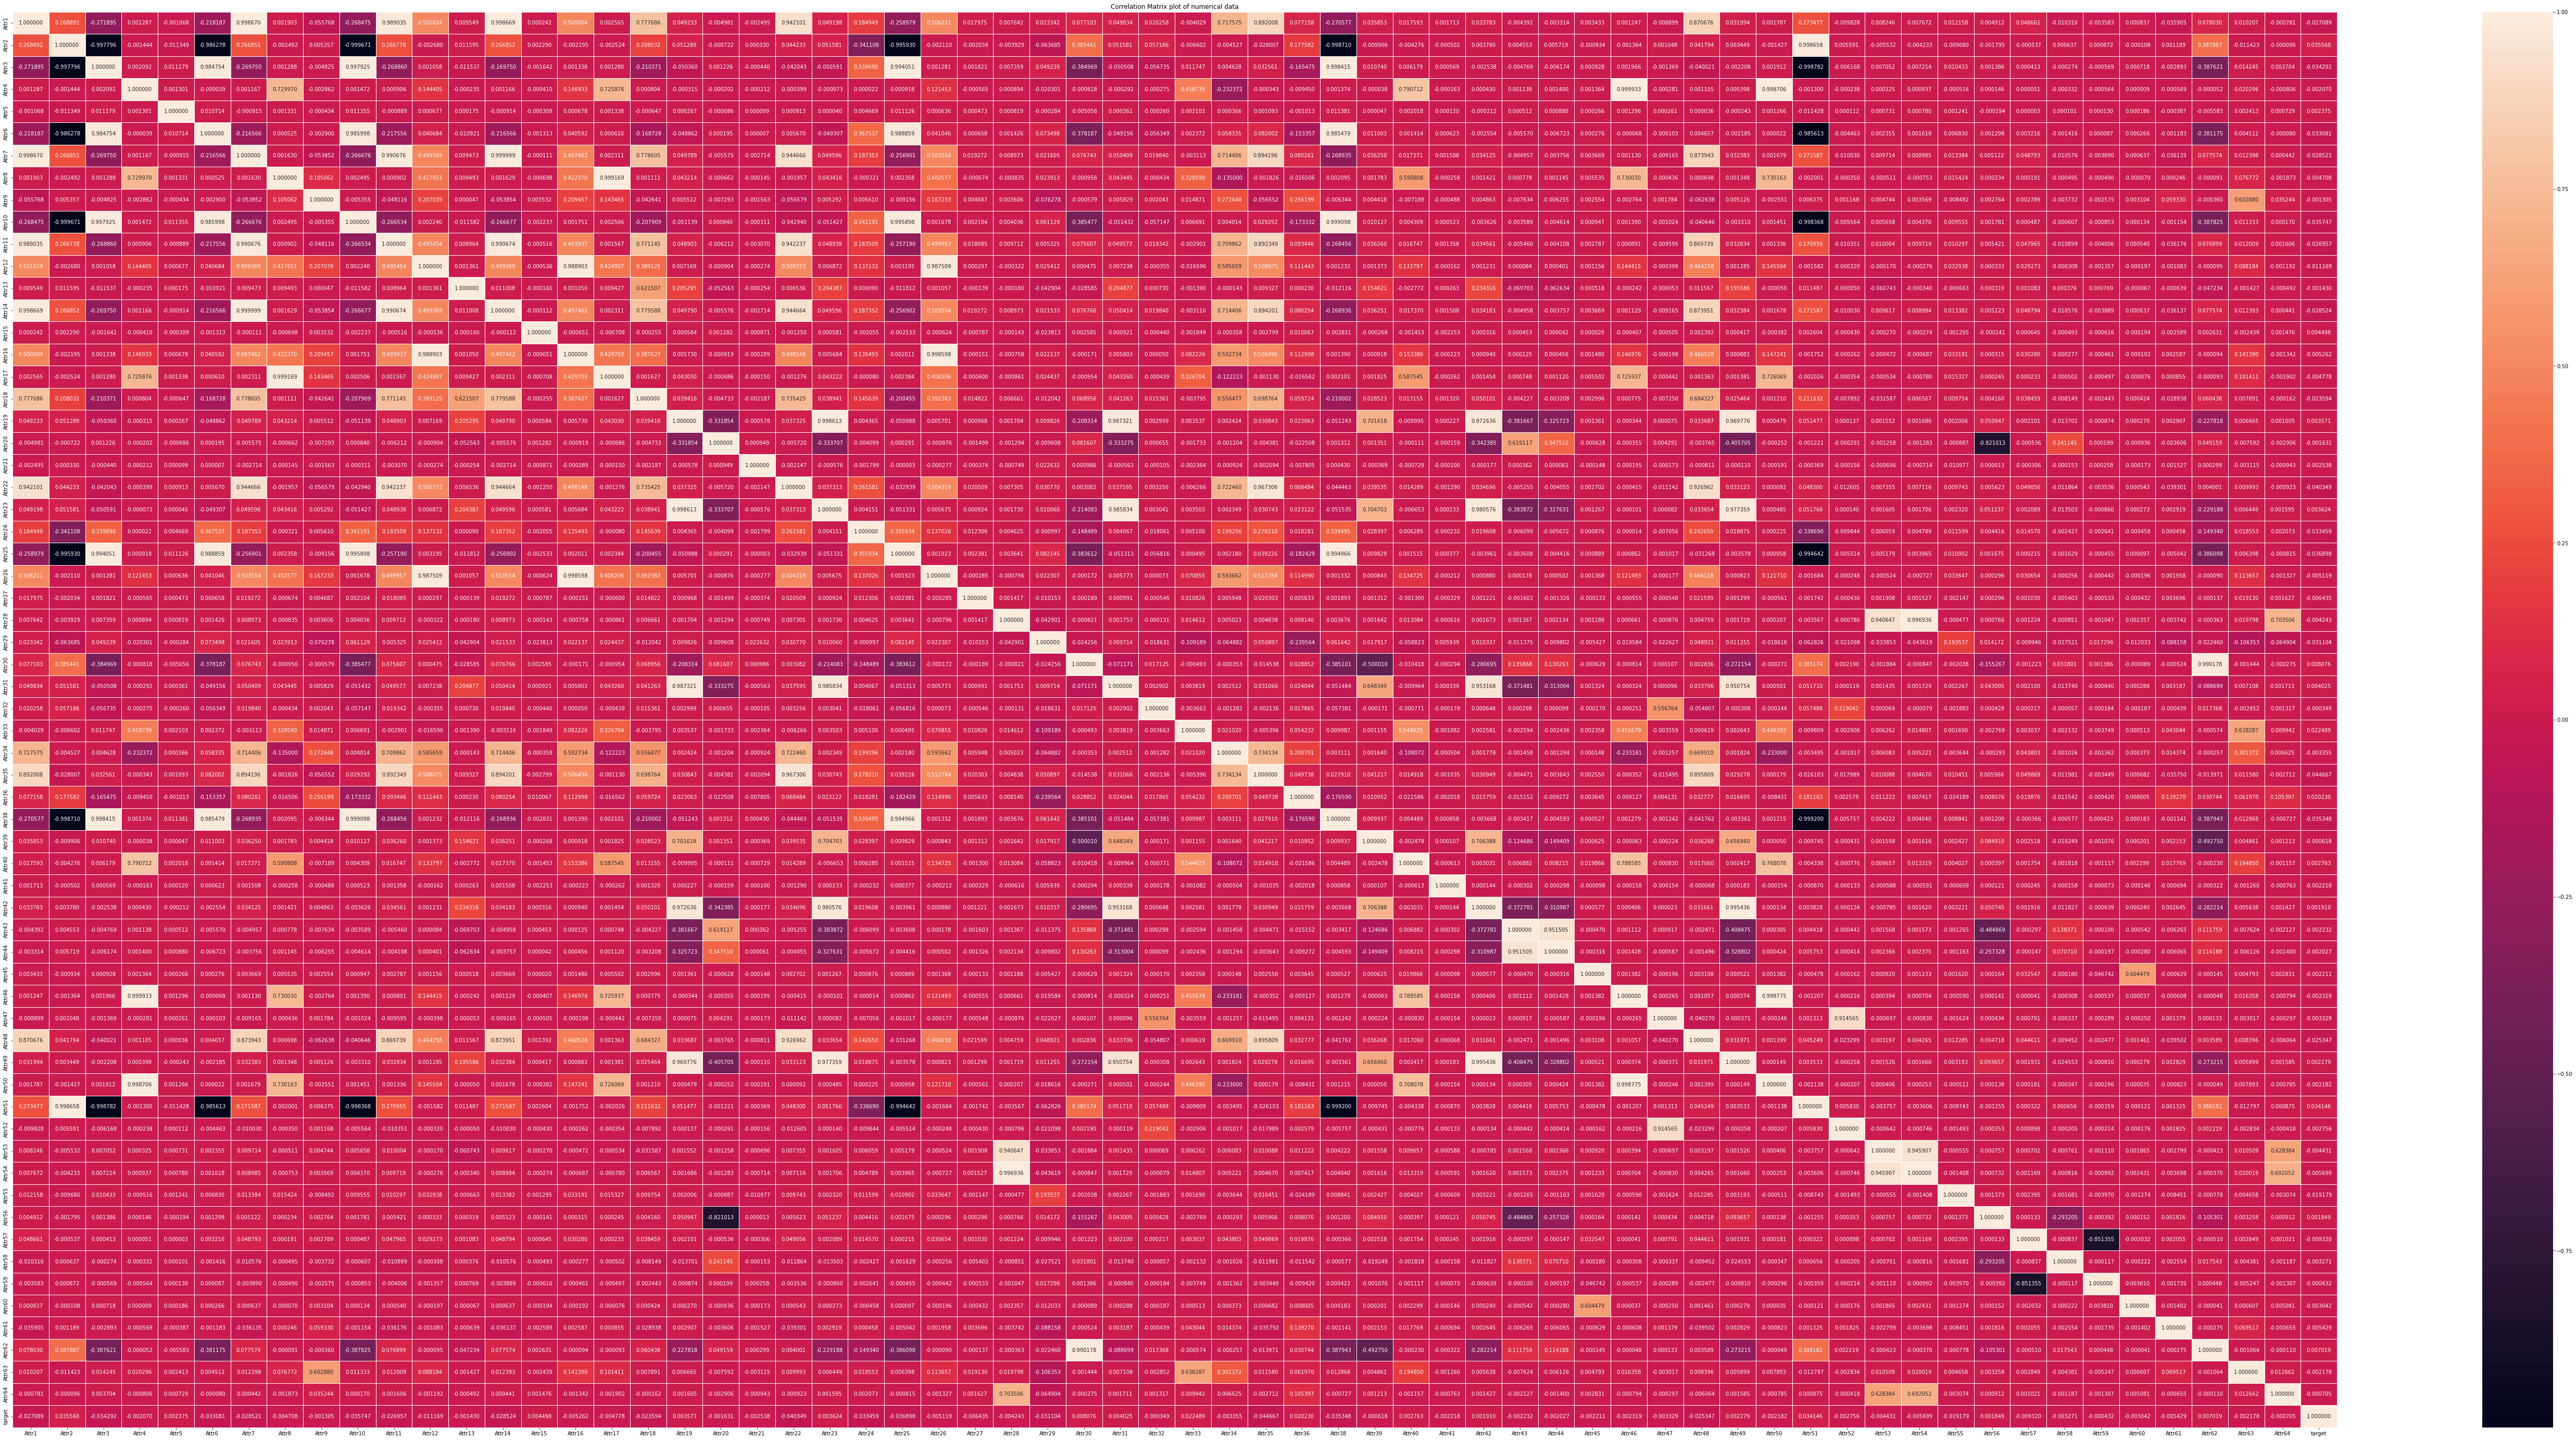

In [18]:
sns.heatmap(ucip[all_num].corr(),annot=True,linewidth=.5,fmt='1f')
plt.title('Correlation Matrix plot of numerical data')
plt.show()

# 3. Splitting data and Feature Engineering

## 3.1 Splitting data

In [19]:
y = ucip['target']
X = ucip.drop(['target','Attr37'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=.2,shuffle=True, random_state= 1)

## 3.2 Feature engineer

### 3.2.1 Standardise numerical variables

In [20]:
standard = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

X_train_scaled[numvars] = standard.fit_transform(X_train_scaled[numvars])
X_val_scaled[numvars] = standard.transform(X_val_scaled[numvars])

X_val_scaled[numvars].head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
8254,0.091483,-0.044147,0.019879,-0.016629,0.013271,0.049855,0.114764,-0.026029,-0.095946,0.039594,...,2.160294,0.004557,0.010090,-0.015761,-0.020117,-0.015168,-0.052360,-0.003056,0.008968,-0.070337
7561,0.025538,-0.020644,0.019626,-0.017094,-0.002129,0.017879,0.031643,-0.027178,0.552239,0.022512,...,-0.102471,-0.001805,0.009295,-0.014807,-0.020458,-0.015382,0.762148,-0.003405,0.110326,-0.030944
3369,0.345051,-0.076468,0.115805,-0.000844,0.014226,0.017879,0.447645,-0.015983,0.044462,0.078323,...,-0.100161,0.017316,0.013188,-0.017238,-0.020458,-0.015295,0.267105,-0.003854,0.439680,0.763467
10457,0.334915,-0.075634,0.076388,-0.006866,0.013794,0.040966,0.303154,-0.016832,-0.085136,0.077490,...,0.345708,0.015839,0.013047,-0.017387,-0.020456,-0.015521,-0.114139,-0.003632,0.226527,-0.071005
9207,-8.258762,0.322283,-0.287091,-0.018986,0.012625,0.017879,-8.174986,-0.029294,0.962325,-0.320348,...,-0.115326,-0.048186,0.079552,-0.008171,-0.020458,-0.015407,0.584210,-0.000558,-0.174988,0.624878


In [21]:
X_train_final = X_train_scaled[numvars]
X_val_final = X_val_scaled[numvars]

# 4. Obtain resampling data

In [22]:
def resampling(ratio=1):
    X_data_list = []
    y_data_list = []
    for single_class in classes:
        if single_class == NearMiss:
            instance = single_class(sampling_strategy = ratio)
            X_data, y_data = instance.fit_resample(X_train_final, y_train.values.ravel())
            X_data_list.append(X_data)
            y_data_list.append(y_data)
            print('{} with {} completed'.format(single_class, ratio))
            print('Resampled dataset shape %s' % Counter(y_data))  
        else:
            instance = single_class(random_state=40, sampling_strategy = ratio)
            X_data, y_data = instance.fit_resample(X_train_final, y_train.values.ravel())
            X_data_list.append(X_data)
            y_data_list.append(y_data)
            print('{} with {} completed'.format(single_class, ratio))
            print('Resampled dataset shape %s' % Counter(y_data))       
    return X_data_list, y_data_list

In [23]:
classes = [RandomOverSampler, SMOTE, BorderlineSMOTE,
           RandomUnderSampler, NearMiss, InstanceHardnessThreshold,
           SMOTEENN, SMOTETomek]

#IR=1
X_data_list1, y_data_list1 = resampling(1)

print(len(X_data_list1),len(y_data_list1))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 1 completed
Resampled dataset shape Counter({0: 7999, 1: 7999})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 1 completed
Resampled dataset shape Counter({0: 7999, 1: 7999})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 1 completed
Resampled dataset shape Counter({0: 7999, 1: 7999})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 1 completed
Resampled dataset shape Counter({0: 403, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 1 completed
Resampled dataset shape Counter({0: 403, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 1 completed
Resampled dataset shape Counter({0: 2025, 1: 403})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 1 completed
Resampled dataset shape Counter({1: 7719, 0: 5676})
<class 'i

In [24]:
#IR=5
X_data_list2, y_data_list2 = resampling(0.2)

print(len(X_data_list2),len(y_data_list2))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.2 completed
Resampled dataset shape Counter({0: 7999, 1: 1599})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.2 completed
Resampled dataset shape Counter({0: 7999, 1: 1599})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.2 completed
Resampled dataset shape Counter({0: 7999, 1: 1599})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.2 completed
Resampled dataset shape Counter({0: 2015, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.2 completed
Resampled dataset shape Counter({0: 2015, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.2 completed
Resampled dataset shape Counter({0: 2025, 1: 403})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.2 completed
Resampled dataset shape Counter({0: 6424, 1: 

In [25]:
#IR=10
X_data_list3, y_data_list3 = resampling(0.1)

print(len(X_data_list3),len(y_data_list3))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.1 completed
Resampled dataset shape Counter({0: 7999, 1: 799})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.1 completed
Resampled dataset shape Counter({0: 7999, 1: 799})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.1 completed
Resampled dataset shape Counter({0: 7999, 1: 799})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.1 completed
Resampled dataset shape Counter({0: 4030, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.1 completed
Resampled dataset shape Counter({0: 4030, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.1 completed
Resampled dataset shape Counter({0: 4601, 1: 403})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.1 completed
Resampled dataset shape Counter({0: 6801, 1: 238

In [26]:
#IR=15
X_data_list4, y_data_list4 = resampling(0.0667)

print(len(X_data_list4),len(y_data_list4))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.0667 completed
Resampled dataset shape Counter({0: 7999, 1: 533})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.0667 completed
Resampled dataset shape Counter({0: 7999, 1: 533})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.0667 completed
Resampled dataset shape Counter({0: 7999, 1: 533})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.0667 completed
Resampled dataset shape Counter({0: 6041, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.0667 completed
Resampled dataset shape Counter({0: 6041, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.0667 completed
Resampled dataset shape Counter({0: 6188, 1: 403})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.0667 completed
Resampled dataset shape Cou

# 5. Model training

## 5.1 Random forest

In [27]:
#grid search for hyper parameter tuning
rf = RandomForestClassifier(random_state=0)                      

param_grid = {'n_estimators': [25, 50, 100],
              'max_features': [2, 4, 8]
              }

gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=0)
gs_rf.fit(X_train_final, y_train.values.ravel()) 
rf_tune = gs_rf.best_estimator_
print("Best CV AUC: %0.4f" % gs_rf.best_score_)
print("Optimal RF meta-parameters:")
print(gs_rf.best_params_)
print(rf_tune)

Best CV AUC: 0.8561
Optimal RF meta-parameters:
{'max_features': 8, 'n_estimators': 100}
RandomForestClassifier(max_features=8, random_state=0)


In [28]:
#run this to skip hyper parameter tuning
rf_tune=RandomForestClassifier(random_state=0, max_features = 8, n_estimators =100)
rf_tune.fit(X_train_final, y_train.values.ravel())

RandomForestClassifier(max_features=8, random_state=0)

In [29]:
from function import evaluation
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,rf_tune)
rf_eva = ['RF', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
rf_eva

['RF', 1.0, 0.831, 0.5, 0.12, 0.345, 0.193]

## 5.2  neural network

In [30]:
# Define model
model = keras.Sequential([ 
    keras.Input(shape=(X_train_final.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation = "sigmoid")
])

# Compile model
model.compile(optimizer = 'adam',
    loss="binary_crossentropy",
    metrics = ["AUC"]
)
print(model.summary())

early_stopping_monitor = EarlyStopping(
    monitor='val_auc',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,041
Trainable params: 1,041
Non-trainable params: 0
_________________________________________________________________
None


2023-06-25 12:02:55.937214: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
# Fit the model
history = model.fit(X_train_final,
                    y_train,
                    epochs = 20,
                    batch_size = 2,
                    validation_data=(X_val_final, y_val),
                    callbacks=[early_stopping_monitor])

Epoch 1/20
4201/4201 [==============================] - 5s 982us/step - loss: 0.2188 - auc: 0.6390 - val_loss: 0.1719 - val_auc: 0.7004
Epoch 2/20
4201/4201 [==============================] - 4s 964us/step - loss: 0.1803 - auc: 0.7252 - val_loss: 0.1701 - val_auc: 0.7123
Epoch 3/20
4201/4201 [==============================] - 4s 932us/step - loss: 0.1766 - auc: 0.7415 - val_loss: 0.1781 - val_auc: 0.7132
Epoch 4/20
4201/4201 [==============================] - 4s 969us/step - loss: 0.1750 - auc: 0.7454 - val_loss: 0.1684 - val_auc: 0.7175
Epoch 5/20
4201/4201 [==============================] - 4s 931us/step - loss: 0.1736 - auc: 0.7529 - val_loss: 0.1697 - val_auc: 0.7180
Epoch 6/20
4201/4201 [==============================] - 4s 933us/step - loss: 0.1713 - auc: 0.7632 - val_loss: 0.1690 - val_auc: 0.7154
Epoch 7/20
4201/4201 [==============================] - 4s 948us/step - loss: 0.1709 - auc: 0.7655 - val_loss: 0.1710 - val_auc: 0.7031
Epoch 8/20
4201/4201 [==========================

In [32]:
from function import evaluation_nn
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation_nn(y_train,X_train_final,y_val,X_val_final,model)
nn_eva = ['NN', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
nn_eva

['NN', 0.79, 0.728, 0.0, 0.0, 0.0, 0.0]

## 5.3 Logit

In [33]:
logit = LogisticRegressionCV(cv=5, random_state=0, max_iter=20000).fit(X_train_final,y_train.values.ravel())

In [34]:
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,logit)
logit_eva = ['logit', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
logit_eva

['logit', 0.676, 0.668, 0.0, 0.0, 0.0, 0.0]

### 5.3.2 Applying resampling methods on logit

In [35]:
def logit_resampling(X_data_list, y_data_list):
    AUC_training_list = []
    AUC_validation_list = []
    precision_list = []
    recall_list = []
    Gmeans_list = []
    F1_list = []
    confusion_matrix_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_lr = logit.fit(X_data, y_data)
        AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_data,X_data,y_val,X_val_final,instance_lr)
        AUC_training_list.append(AUC_training)
        AUC_validation_list.append(AUC_validation)
        precision_list.append(precison)
        recall_list.append(recall)
        Gmeans_list.append(Gmeans)
        F1_list.append(F1)
        confusion_matrix_list.append(confusion_matrix)
        #print evaluation lists
    print("AUC validation:{}".format(AUC_validation_list))
    return AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list

In [36]:
#IR =1
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list1, y_data_list1)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog = pd.DataFrame(dic)
dflog.loc[len(dflog)] = logit_eva
dflog

AUC validation:[0.747, 0.746, 0.725, 0.717, 0.657, 0.737, 0.743, 0.746]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.797,0.747,0.090,0.728,0.695,0.160
1,SMOTE,0.809,0.746,0.090,0.728,0.695,0.160
2,BorderlineSMOTE,0.843,0.725,0.088,0.620,0.661,0.154
3,RandomUnderSampler,0.827,0.717,0.090,0.663,0.679,0.159
4,NearMiss,0.930,0.657,0.066,0.837,0.616,0.122
5,InstanceHardnessThreshold,0.973,0.737,0.092,0.696,0.690,0.162
6,SMOTEENN,0.859,0.743,0.077,0.793,0.671,0.141
7,SMOTETomek,0.809,0.746,0.090,0.728,0.695,0.161
8,logit,0.676,0.668,0.000,0.000,0.000,0.000


In [37]:
#IR = 5
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list2, y_data_list2)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog2 = pd.DataFrame(dic)
dflog2.loc[len(dflog2)] = logit_eva
dflog2

AUC validation:[0.726, 0.718, 0.719, 0.669, 0.702, 0.737, 0.71, 0.718]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.783,0.726,0.111,0.033,0.179,0.050
1,SMOTE,0.799,0.718,0.200,0.065,0.254,0.098
2,BorderlineSMOTE,0.822,0.719,0.167,0.076,0.273,0.104
3,RandomUnderSampler,0.679,0.669,0.000,0.000,0.000,0.000
4,NearMiss,0.867,0.702,0.083,0.457,0.592,0.140
5,InstanceHardnessThreshold,0.973,0.737,0.092,0.696,0.690,0.162
6,SMOTEENN,0.863,0.710,0.153,0.141,0.369,0.147
7,SMOTETomek,0.803,0.718,0.241,0.076,0.274,0.116
8,logit,0.676,0.668,0.000,0.000,0.000,0.000


In [38]:
#IR = 10
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list3, y_data_list3)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog3 = pd.DataFrame(dic)
dflog3.loc[len(dflog3)] = logit_eva
dflog3

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


AUC validation:[0.668, 0.673, 0.668, 0.669, 0.692, 0.729, 0.675, 0.674]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.676,0.668,0.000,0.000,0.000,0.00
1,SMOTE,0.676,0.673,0.000,0.000,0.000,0.00
2,BorderlineSMOTE,0.713,0.668,0.000,0.000,0.000,0.00
3,RandomUnderSampler,0.675,0.669,0.000,0.000,0.000,0.00
4,NearMiss,0.819,0.692,0.087,0.196,0.421,0.12
5,InstanceHardnessThreshold,0.917,0.729,0.120,0.293,0.514,0.17
6,SMOTEENN,0.745,0.675,0.000,0.000,0.000,0.00
7,SMOTETomek,0.679,0.674,0.000,0.000,0.000,0.00
8,logit,0.676,0.668,0.000,0.000,0.000,0.00


In [39]:
#IR = 15
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list4, y_data_list4)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog4 = pd.DataFrame(dic)
dflog4.loc[len(dflog4)] = logit_eva
dflog4

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


AUC validation:[0.66, 0.67, 0.667, 0.669, 0.682, 0.743, 0.657, 0.671]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.683,0.660,0.000,0.000,0.000,0.000
1,SMOTE,0.679,0.670,0.000,0.000,0.000,0.000
2,BorderlineSMOTE,0.689,0.667,0.000,0.000,0.000,0.000
3,RandomUnderSampler,0.677,0.669,0.000,0.000,0.000,0.000
4,NearMiss,0.740,0.682,0.040,0.022,0.146,0.028
5,InstanceHardnessThreshold,0.868,0.743,0.156,0.185,0.420,0.169
6,SMOTEENN,0.815,0.657,0.000,0.000,0.000,0.000
7,SMOTETomek,0.676,0.671,0.000,0.000,0.000,0.000
8,logit,0.676,0.668,0.000,0.000,0.000,0.000


### Aggregate and output result

In [47]:
#aggregate AUC validation
dflogit = pd.concat([dflog4.iloc[:,2],dflog3.iloc[:,2],dflog2.iloc[:,2],dflog.iloc[:,2]],axis=1)
dflogit.columns = ['1:15', '1:10', '1:5', '1:1']
dflogit.index = dflog4.iloc[:,0]
dflogit

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.660,0.668,0.726,0.747
SMOTE,0.670,0.673,0.718,0.746
BorderlineSMOTE,0.667,0.668,0.719,0.725
RandomUnderSampler,0.669,0.669,0.669,0.717
NearMiss,0.682,0.692,0.702,0.657
InstanceHardnessThreshold,0.743,0.729,0.737,0.737
SMOTEENN,0.657,0.675,0.710,0.743
SMOTETomek,0.671,0.674,0.718,0.746
logit,0.668,0.668,0.668,0.668


In [48]:
import os
path = '/Users/kelly/Desktop/code_final/UCI_P/result'
file_path = path + '/ucip_logit_auc.csv'
os.makedirs(path, exist_ok=True)
dflogit.to_csv(file_path, index =True, encoding = 'utf-8-sig') 

In [49]:
#aggregate gmeans
logit_gmeans = pd.concat([dflog4.iloc[:,5],dflog3.iloc[:,5],dflog2.iloc[:,5],dflog.iloc[:,5]],axis=1)
logit_gmeans.columns = ['1:15', '1:10', '1:5', '1:1']
logit_gmeans.index = dflog4.iloc[:,0]
logit_gmeans

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.000,0.000,0.179,0.695
SMOTE,0.000,0.000,0.254,0.695
BorderlineSMOTE,0.000,0.000,0.273,0.661
RandomUnderSampler,0.000,0.000,0.000,0.679
NearMiss,0.146,0.421,0.592,0.616
InstanceHardnessThreshold,0.420,0.514,0.690,0.690
SMOTEENN,0.000,0.000,0.369,0.671
SMOTETomek,0.000,0.000,0.274,0.695
logit,0.000,0.000,0.000,0.000


In [50]:
logit_gmeans.to_csv(path + '/ucip_logit_gmeans.csv', index =True, encoding = 'utf-8-sig') 

In [51]:
#aggregate fmeasure
logit_fmeasure = pd.concat([dflog4.iloc[:,6],dflog3.iloc[:,6],dflog2.iloc[:,6],dflog.iloc[:,6]],axis=1)
logit_fmeasure.columns = ['1:15', '1:10', '1:5', '1:1']
logit_fmeasure.index = dflog4.iloc[:,0]
logit_fmeasure

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.000,0.00,0.050,0.160
SMOTE,0.000,0.00,0.098,0.160
BorderlineSMOTE,0.000,0.00,0.104,0.154
RandomUnderSampler,0.000,0.00,0.000,0.159
NearMiss,0.028,0.12,0.140,0.122
InstanceHardnessThreshold,0.169,0.17,0.162,0.162
SMOTEENN,0.000,0.00,0.147,0.141
SMOTETomek,0.000,0.00,0.116,0.161
logit,0.000,0.00,0.000,0.000


In [52]:
logit_fmeasure.to_csv(path + '/ucip_logit_fmeasure.csv', index =True, encoding = 'utf-8-sig') 

## 5.4 XGBoost

### 5.4.1 training XGBoost

In [53]:
#perform hyper parameter grid search
xgb_param_grid = {
    'colsample_bytree': np.linspace(0.1, 0.8, 3), # Subsample ratio of columns when constructing each tree
    'n_estimators': [50,75,100],  # Number of gradient boosted trees
    'max_depth': [3, 5, 8],   # max depth of decision trees
    'learning_rate': np.linspace(0.01, 0.1, 3), #Boosting learning rate
    'subsample': np.linspace(0.5, 0.8, 3)}  # Subsample ratio of the training instance

gs_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric ='auc'), 
                      param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=0)

gs_xgb.fit(X_train_final, y_train.values.ravel())
xgb_tune = gs_xgb.best_estimator_
print("Best CV AUC: %0.4f" % gs_xgb.best_score_)
print("Optimal XGB meta-parameters:")
print(gs_xgb.best_params_)
print(xgb_tune)

Best CV AUC: 0.9248
Optimal XGB meta-parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [54]:
#run this to skip xgb tuning
xgb_tune = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
xgb_tune.fit(X_train_final, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [55]:
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,xgb_tune)
xgb_eva=['xgb', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
xgb_eva

['xgb', 1.0, 0.906, 0.933, 0.304, 0.551, 0.459]

### 5.4.2 Apply resampling methods on  XGBoost

In [56]:
def xgb_resampling(X_data_list, y_data_list):
    AUC_training_list = []
    AUC_validation_list = []
    precision_list = []
    recall_list = []
    Gmeans_list = []
    F1_list = []
    confusion_matrix_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = xgb_tune.fit(X_data, y_data,eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_data,X_data,y_val,X_val_final,instance_xgb)
        AUC_training_list.append(AUC_training)
        AUC_validation_list.append(AUC_validation)
        precision_list.append(precison)
        recall_list.append(recall)
        Gmeans_list.append(Gmeans)
        F1_list.append(F1)
        confusion_matrix_list.append(confusion_matrix)
        #print evaluation lists
    print("AUC validation:{}".format(AUC_validation_list))
    return AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list

In [ ]:
#IR =1
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list1, y_data_list1)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb = pd.DataFrame(dic)
dfxgb.loc[len(dfxgb)] = xgb_eva
dfxgb

In [ ]:
#IR =5
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list2, y_data_list2)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb2 = pd.DataFrame(dic)
dfxgb2.loc[len(dfxgb2)] = xgb_eva
dfxgb2

In [ ]:
#IR =10
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list3, y_data_list3)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb3 = pd.DataFrame(dic)
dfxgb3.loc[len(dfxgb3)] = xgb_eva
dfxgb3

In [ ]:
#IR =15
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list4, y_data_list4)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb4 = pd.DataFrame(dic)
dfxgb4.loc[len(dfxgb4)] = xgb_eva
dfxgb4

### Aggregate and output results

In [61]:
#aggregate AUC validation
dfxgboost = pd.concat([dfxgb4.iloc[:,2],dfxgb3.iloc[:,2],dfxgb2.iloc[:,2],dfxgb.iloc[:,2]],axis=1)
dfxgboost.columns = ['1:15', '1:10', '1:5', '1:1']
dfxgboost.index = dfxgb4.iloc[:,0]
dfxgboost

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.911,0.895,0.894,0.889
SMOTE,0.906,0.895,0.888,0.861
BorderlineSMOTE,0.902,0.888,0.880,0.857
RandomUnderSampler,0.903,0.905,0.905,0.862
NearMiss,0.897,0.841,0.791,0.697
InstanceHardnessThreshold,0.889,0.855,0.810,0.810
SMOTEENN,0.735,0.779,0.843,0.862
SMOTETomek,0.882,0.883,0.892,0.867
xgb,0.906,0.906,0.906,0.906


In [62]:
dfxgboost.to_csv(path + '/ucip_xgb_auc.csv', index = True, encoding = 'utf-8-sig') 

In [63]:
#aggregate gmeans
xgb_gmeans = pd.concat([dfxgb4.iloc[:,5],dfxgb3.iloc[:,5],dfxgb2.iloc[:,5],dfxgb.iloc[:,5]],axis=1)
xgb_gmeans.columns = ['1:15', '1:10', '1:5', '1:1']
xgb_gmeans.index = dfxgb4.iloc[:,0]
xgb_gmeans

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.570,0.570,0.615,0.729
SMOTE,0.521,0.477,0.569,0.716
BorderlineSMOTE,0.499,0.477,0.539,0.700
RandomUnderSampler,0.531,0.579,0.655,0.767
NearMiss,0.564,0.622,0.704,0.485
InstanceHardnessThreshold,0.638,0.729,0.719,0.719
SMOTEENN,0.104,0.346,0.517,0.739
SMOTETomek,0.489,0.465,0.550,0.708
xgb,0.551,0.551,0.551,0.551


In [64]:
xgb_gmeans.to_csv(path + '/ucip_xgb_gmeans.csv', index = True, encoding = 'utf-8-sig') 

In [65]:
#aggregate fmeasure
xgb_fmeasure = pd.concat([dfxgb4.iloc[:,6],dfxgb3.iloc[:,6],dfxgb2.iloc[:,6],dfxgb.iloc[:,6]],axis=1)
xgb_fmeasure.columns = ['1:15', '1:10', '1:5', '1:1']
xgb_fmeasure.index = dfxgb4.iloc[:,0]
xgb_fmeasure

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.472,0.476,0.496,0.449
SMOTE,0.413,0.359,0.432,0.392
BorderlineSMOTE,0.380,0.341,0.388,0.423
RandomUnderSampler,0.430,0.463,0.503,0.232
NearMiss,0.349,0.227,0.174,0.101
InstanceHardnessThreshold,0.373,0.296,0.176,0.176
SMOTEENN,0.021,0.210,0.336,0.296
SMOTETomek,0.376,0.336,0.415,0.381
xgb,0.459,0.459,0.459,0.459


In [66]:
xgb_fmeasure.to_csv(path + '/ucip_xgb_fmeasure.csv', index = True, encoding = 'utf-8-sig') 

In [67]:
#aggregate the evaluation results for four models
models = [logit_eva[0], rf_eva[0],xgb_eva[0],nn_eva[0]]
AUC_val = [logit_eva[2], rf_eva[2],xgb_eva[2],nn_eva[2]]
Gmeans = [logit_eva[5], rf_eva[5],xgb_eva[5],nn_eva[5]]
Fmeasure = [logit_eva[6], rf_eva[6],xgb_eva[6],nn_eva[6]]
dic ={'Model': models, 'AUC_validation':AUC_val, 'G-means':Gmeans, 'F1-score':Fmeasure}
models_eva = pd.DataFrame(dic)
models_eva

,Model,AUC_validation,G-means,F1-score
0,logit,0.668,0.000,0.000
1,RF,0.831,0.345,0.193
2,xgb,0.906,0.551,0.459
3,NN,0.728,0.000,0.000


In [68]:
models_eva.to_csv(path + '/ucip_models.csv', index = True, encoding = 'utf-8-sig') 

# 6. XAI

## 6.1 SHAP fearure importance

### 6.1.1 Calculate SHAP feature importance

In [69]:
instance =xgb_tune.fit(X_train_final, y_train.values.ravel())
explainer_xgb = shap.TreeExplainer(xgb_tune, data=X_train_final, 
                                   feature_perturbation='interventional', model_output='probability')
shap_values_xgb = explainer_xgb.shap_values(X_train_final)
print(shap_values_xgb.shape)

result__ = pd.DataFrame(shap_values_xgb, columns = X_train_final.columns)

#for global importance, we average the absolute Shapley values per feature across the data: 
vals__ = np.abs(result__.values).mean(0).round(3)
shap_importance = pd.DataFrame(list(zip(X_train_final.columns, vals__)),
                                  columns=['feature','xgb'])
print(shap_importance.head())

 96%|=================== | 8102/8402 [00:25<00:00]       

(8402, 63)
  feature    xgb
0   Attr1  0.001
1   Attr2  0.001
2   Attr3  0.001
3   Attr4  0.001
4   Attr5  0.007


In [70]:
def shap_generator(X_data_list, y_data_list,model):
    vals_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = model.fit(X_data, y_data,
                                 eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        explainer_instance = shap.TreeExplainer(model, data=X_data, 
                                                feature_perturbation='interventional', model_output='probability')
        shap_values_instance = explainer_instance.shap_values(X_data)
        result = pd.DataFrame(shap_values_instance, columns = X_data.columns)
        vals = np.abs(result.values).mean(0).round(3)
        
        vals_list.append(vals)
    return vals_list

In [71]:
#extract RUS,IHT resampled data sets
#order: rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15

RE_Xlist= [X_data_list1[3],X_data_list2[3],X_data_list3[3], X_data_list4[3],
           X_data_list1[4],X_data_list2[4], X_data_list3[4], X_data_list4[4]]
RE_ylist =[y_data_list1[3],y_data_list2[3],y_data_list3[3], y_data_list4[3],
           y_data_list1[4],y_data_list2[4], y_data_list3[4], y_data_list4[4]]

In [ ]:
shap_list = shap_generator(RE_Xlist, RE_ylist,xgb_tune)

In [73]:
#rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
shap_importance['rus1'] = shap_list[0]
shap_importance['rus5'] = shap_list[1]
shap_importance['rus10'] = shap_list[2]
shap_importance['rus15'] = shap_list[3]
shap_importance['iht1'] = shap_list[4]
shap_importance['iht5'] = shap_list[5]
shap_importance['iht10'] = shap_list[6]
shap_importance['iht15'] = shap_list[7]

shap_importance.head()

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
0,Attr1,0.001,0.004,0.003,0.000,0.001,0.007,0.001,0.003,0.001
1,Attr2,0.001,0.003,0.001,0.001,0.001,0.001,0.003,0.001,0.000
2,Attr3,0.001,0.002,0.005,0.003,0.001,0.006,0.001,0.001,0.001
3,Attr4,0.001,0.007,0.002,0.003,0.001,0.002,0.002,0.000,0.001
4,Attr5,0.007,0.022,0.024,0.015,0.010,0.002,0.009,0.008,0.007


In [74]:
shap_importance.to_csv(path + '/shap_importance.csv', index = True, encoding = 'utf-8-sig') 

### 6.1.2  SHAP rank correlation

In [75]:
rank_shap = shap_importance.corr(method = 'spearman').round(3)
print(rank_shap)

         xgb   rus1   rus5  rus10  rus15   iht1   iht5  iht10  iht15
xgb    1.000  0.747  0.837  0.801  0.859  0.568  0.751  0.725  0.774
rus1   0.747  1.000  0.832  0.766  0.769  0.620  0.712  0.733  0.755
rus5   0.837  0.832  1.000  0.846  0.812  0.691  0.740  0.846  0.825
rus10  0.801  0.766  0.846  1.000  0.826  0.547  0.773  0.810  0.866
rus15  0.859  0.769  0.812  0.826  1.000  0.565  0.756  0.736  0.828
iht1   0.568  0.620  0.691  0.547  0.565  1.000  0.681  0.671  0.573
iht5   0.751  0.712  0.740  0.773  0.756  0.681  1.000  0.845  0.766
iht10  0.725  0.733  0.846  0.810  0.736  0.671  0.845  1.000  0.887
iht15  0.774  0.755  0.825  0.866  0.828  0.573  0.766  0.887  1.000


In [76]:
rank_shap.to_csv(path + '/rank_shap.csv', index = True, encoding = 'utf-8-sig') 

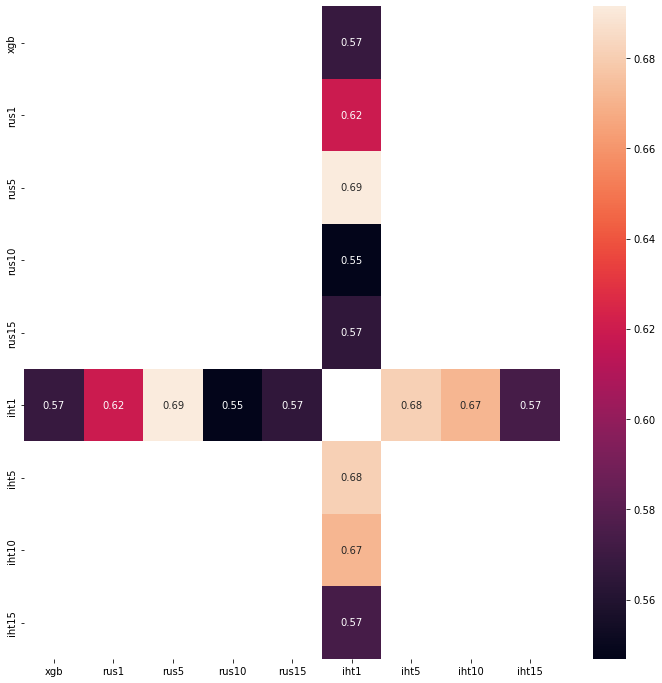

In [77]:
f,ax = plt.subplots(figsize=(12, 12))
snsfilter = sns.heatmap(shap_importance.corr(method = 'spearman')[(shap_importance.corr(method = 'spearman') <= 0.692)],
            annot=True);

### 6.1.3  SHAP feature importance visualisation

In [78]:
#select top 10 features for original xgb
shap_top10 = shap_importance.sort_values(['xgb'], ascending=[False])
shap_top10 = shap_top10.head(10)
shap_top10

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
26,Attr27,0.015,0.113,0.061,0.036,0.021,0.099,0.058,0.030,0.020
44,Attr46,0.011,0.050,0.034,0.021,0.015,0.021,0.022,0.015,0.012
12,Attr13,0.008,0.033,0.019,0.015,0.009,0.022,0.015,0.007,0.007
56,Attr58,0.007,0.029,0.023,0.016,0.009,0.028,0.023,0.011,0.008
37,Attr39,0.007,0.048,0.021,0.016,0.009,0.020,0.010,0.008,0.005
4,Attr5,0.007,0.022,0.024,0.015,0.010,0.002,0.009,0.008,0.007
23,Attr24,0.006,0.027,0.023,0.011,0.008,0.027,0.027,0.015,0.010
25,Attr26,0.006,0.034,0.026,0.013,0.009,0.030,0.008,0.012,0.007
20,Attr21,0.006,0.037,0.021,0.014,0.009,0.008,0.009,0.006,0.007
33,Attr34,0.005,0.028,0.017,0.011,0.007,0.025,0.017,0.010,0.005


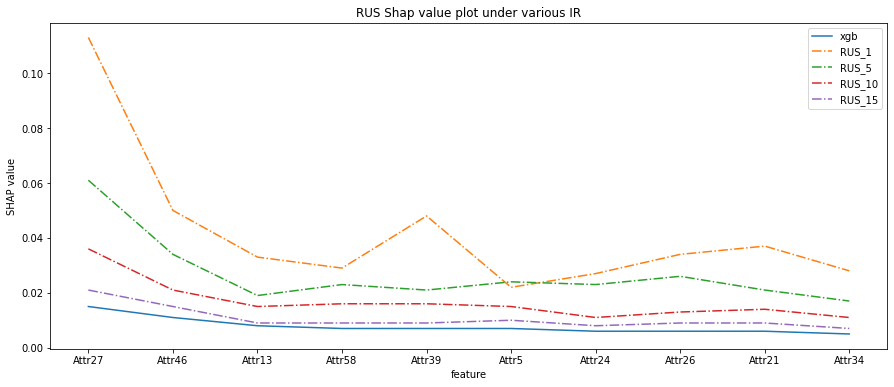

In [79]:
#1.aggeragate by approaches
#rus under different IR
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()
rus_1 =shap_top10['rus1'].tolist()
rus_5 =shap_top10['rus5'].tolist()
rus_10 =shap_top10['rus10'].tolist()
rus_15 =shap_top10['rus15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, rus_1, '-.', label ='RUS_1')
plt.plot(x, rus_5, '-.', label ='RUS_5')
plt.plot(x, rus_10, '-.', label ='RUS_10')
plt.plot(x, rus_15, '-.', label ='RUS_15')

plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('RUS Shap value plot under various IR')
plt.show()

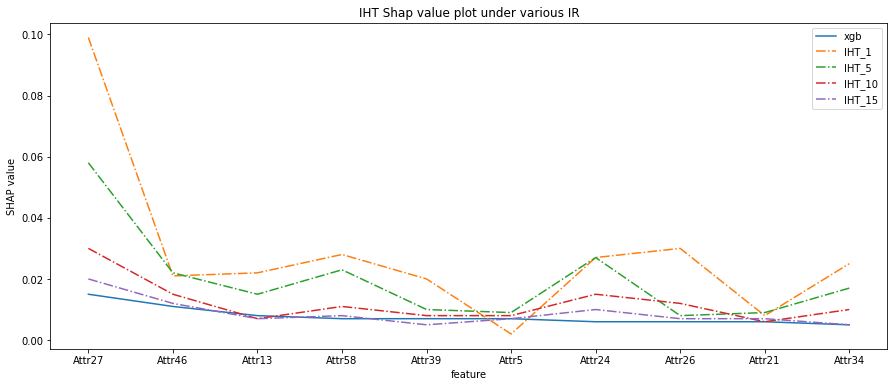

In [80]:
#iht under different IR
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()
iht_1 =shap_top10['iht1'].tolist()
iht_5 =shap_top10['iht5'].tolist()
iht_10 =shap_top10['iht10'].tolist()
iht_15 =shap_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, iht_1, '-.', label ='IHT_1')
plt.plot(x, iht_5, '-.', label ='IHT_5')
plt.plot(x, iht_10, '-.', label ='IHT_10')
plt.plot(x, iht_15, '-.', label ='IHT_15')

plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('IHT Shap value plot under various IR')
plt.show()

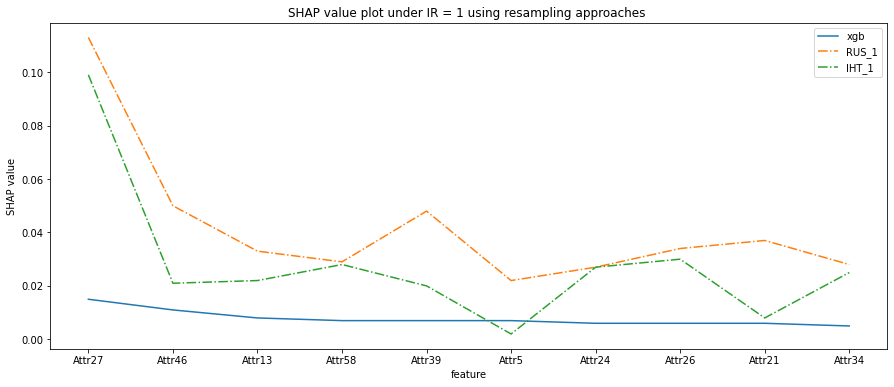

In [81]:
#aggeragate by ratio
#IR=1 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_1 =shap_top10['rus1'].tolist()
IHT_1 =shap_top10['iht1'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_1, '-.', label ='RUS_1')
plt.plot(x, IHT_1, '-.', label ='IHT_1')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 1 using resampling approaches ')
plt.show()

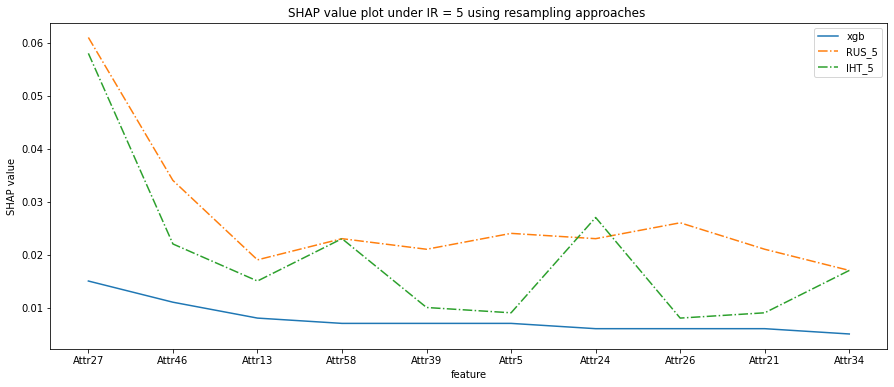

In [82]:
#IR=5 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_5 =shap_top10['rus5'].tolist()
IHT_5 =shap_top10['iht5'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_5, '-.', label ='RUS_5')
plt.plot(x, IHT_5, '-.', label ='IHT_5')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 5 using resampling approaches ')
plt.show()

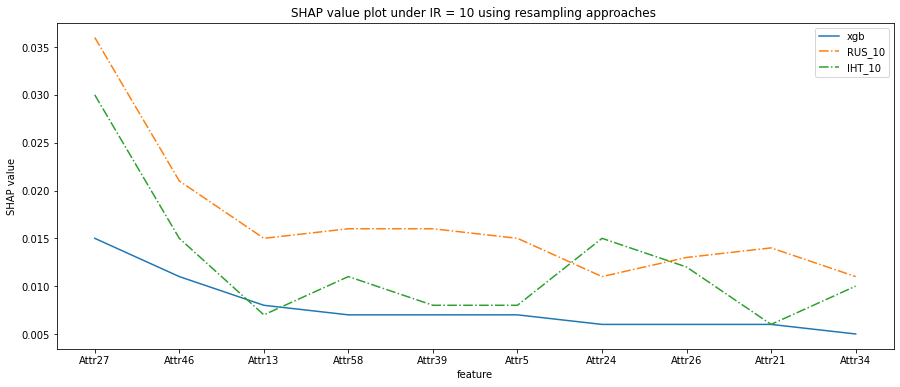

In [83]:
#IR=10 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_10 =shap_top10['rus10'].tolist()
IHT_10 =shap_top10['iht10'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_10, '-.', label ='RUS_10')
plt.plot(x, IHT_10, '-.', label ='IHT_10')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 10 using resampling approaches ')
plt.show()

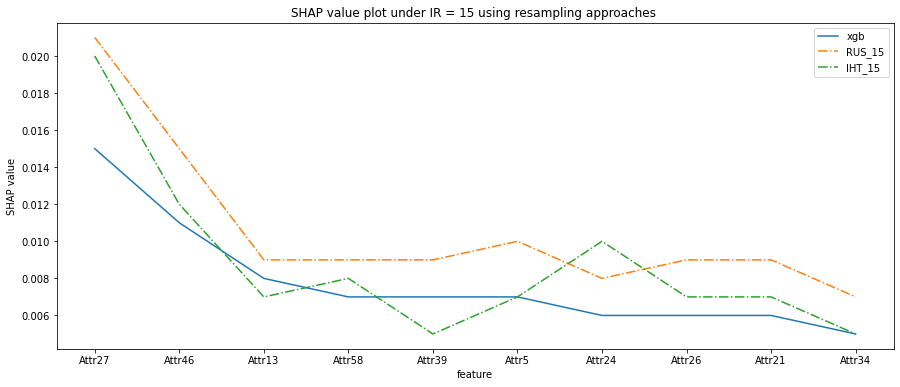

In [84]:
#IR=15 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_15 =shap_top10['rus15'].tolist()
IHT_15 =shap_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_15, '-.', label ='RUS_15')
plt.plot(x, IHT_15, '-.', label ='IHT_15')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 15 using resampling approaches ')
plt.show()

## 6.2 PFI

### 6.2.1 Calculate PFI

In [85]:
instance =xgb_tune.fit(X_train_final, y_train.values.ravel())
pfi_xgb = permutation_importance(xgb_tune, X_train_final, y_train, scoring='roc_auc', n_repeats=5, random_state=1)
pfi_importance = pd.concat([pd.DataFrame(X_train_final.columns),pd.DataFrame(pfi_xgb.importances_mean.round(3))],axis = 1)
pfi_importance = pfi_importance.set_axis(['feature','xgb'], axis='columns')
pfi_importance.head()

,feature,xgb
0,Attr1,0.000
1,Attr2,0.000
2,Attr3,0.000
3,Attr4,0.000
4,Attr5,0.005


In [86]:
def pfi_generator(X_data_list, y_data_list, model):
    pfi_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = model.fit(X_data, y_data,eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        pfi_xgb = permutation_importance(model, X_data, y_data, scoring='roc_auc', n_repeats=5, random_state=1)
        pfi_value = pfi_xgb.importances_mean.round(3) 
        pfi_list.append(pfi_value)
    return pfi_list

In [ ]:
pfi_list = pfi_generator(RE_Xlist, RE_ylist,xgb_tune)

In [88]:
#rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
pfi_importance['rus1'] = pfi_list[0]
pfi_importance['rus5'] = pfi_list[1]
pfi_importance['rus10'] = pfi_list[2]
pfi_importance['rus15'] = pfi_list[3]
pfi_importance['iht1'] = pfi_list[4]
pfi_importance['iht5'] = pfi_list[5]
pfi_importance['iht10'] = pfi_list[6]
pfi_importance['iht15'] = pfi_list[7]

pfi_importance.head()

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
0,Attr1,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000
1,Attr2,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000
2,Attr3,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000
3,Attr4,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000
4,Attr5,0.005,0.001,0.003,0.004,0.006,0.0,0.0,0.001,0.002


In [89]:
pfi_importance.to_csv(path + '/pfi_importance.csv', index = True, encoding = 'utf-8-sig') 

### 6.2.2 PFI rank correlation

In [90]:
rank_pfi = pfi_importance.corr(method = 'spearman').round(3)
print(rank_pfi)

         xgb   rus1   rus5  rus10  rus15   iht1   iht5  iht10  iht15
xgb    1.000  0.743  0.787  0.780  0.958  0.574  0.437  0.684  0.787
rus1   0.743  1.000  0.930  0.836  0.770  0.598  0.578  0.908  0.930
rus5   0.787  0.930  1.000  0.892  0.817  0.561  0.557  0.859  0.999
rus10  0.780  0.836  0.892  1.000  0.813  0.492  0.491  0.770  0.892
rus15  0.958  0.770  0.817  0.813  1.000  0.591  0.445  0.708  0.817
iht1   0.574  0.598  0.561  0.492  0.591  1.000  0.701  0.664  0.545
iht5   0.437  0.578  0.557  0.491  0.445  0.701  1.000  0.648  0.548
iht10  0.684  0.908  0.859  0.770  0.708  0.664  0.648  1.000  0.848
iht15  0.787  0.930  0.999  0.892  0.817  0.545  0.548  0.848  1.000


In [91]:
rank_pfi.to_csv(path + '/rank_pfi.csv', index = True, encoding = 'utf-8-sig') 

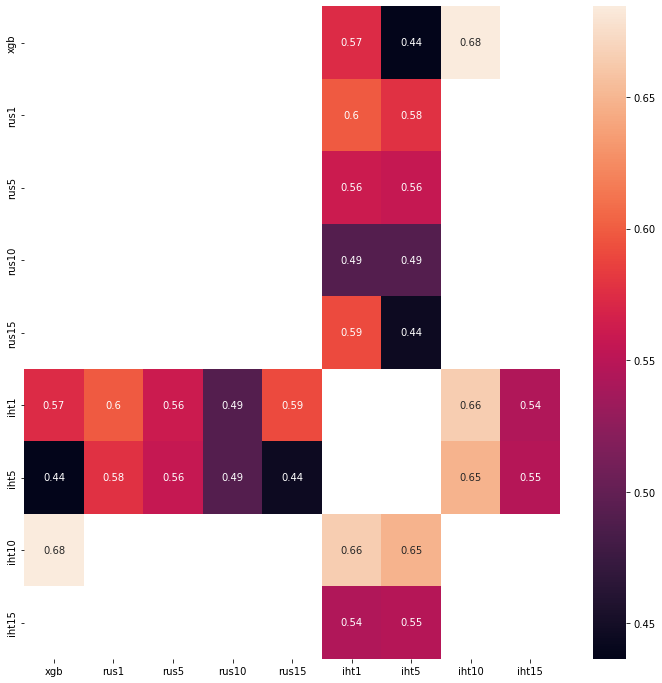

In [92]:
f,ax = plt.subplots(figsize=(12, 12))
snsfilter = sns.heatmap(pfi_importance.corr(method = 'spearman')[(pfi_importance.corr(method = 'spearman') <= 0.695)],
            annot=True);


### 6.2.3 PFI feature importance visualisation

In [93]:
#select top 10 features for original xgb
pfi_top10 = pfi_importance.sort_values(['xgb'], ascending=[False])
pfi_top10 = pfi_top10.head(10)
pfi_top10

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
26,Attr27,0.080,0.096,0.077,0.095,0.079,0.057,0.057,0.074,0.068
44,Attr46,0.014,0.001,0.004,0.011,0.011,0.000,0.000,0.003,0.007
56,Attr58,0.006,0.001,0.005,0.007,0.005,0.001,0.002,0.004,0.005
4,Attr5,0.005,0.001,0.003,0.004,0.006,0.000,0.000,0.001,0.002
33,Attr34,0.003,0.001,0.002,0.003,0.003,0.002,0.000,0.001,0.001
20,Attr21,0.002,0.001,0.001,0.002,0.002,0.000,0.000,0.000,0.002
28,Attr29,0.001,0.000,0.000,0.000,0.001,0.001,0.000,0.000,0.000
37,Attr39,0.001,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000
23,Attr24,0.001,0.000,0.001,0.001,0.001,0.000,0.000,0.000,0.001
54,Attr56,0.001,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000


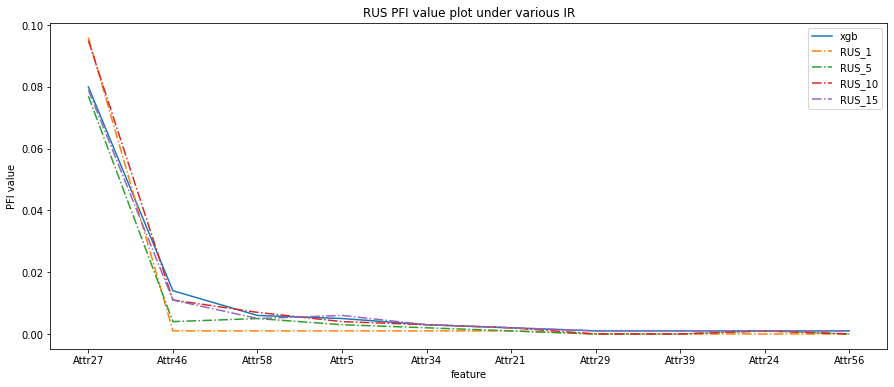

In [94]:
#1.aggeragate by approaches
#rus under different IR
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()
rus_1 =pfi_top10['rus1'].tolist()
rus_5 =pfi_top10['rus5'].tolist()
rus_10 =pfi_top10['rus10'].tolist()
rus_15 =pfi_top10['rus15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, rus_1, '-.', label ='RUS_1')
plt.plot(x, rus_5, '-.', label ='RUS_5')
plt.plot(x, rus_10, '-.', label ='RUS_10')
plt.plot(x, rus_15, '-.', label ='RUS_15')

plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('RUS PFI value plot under various IR')
plt.show()


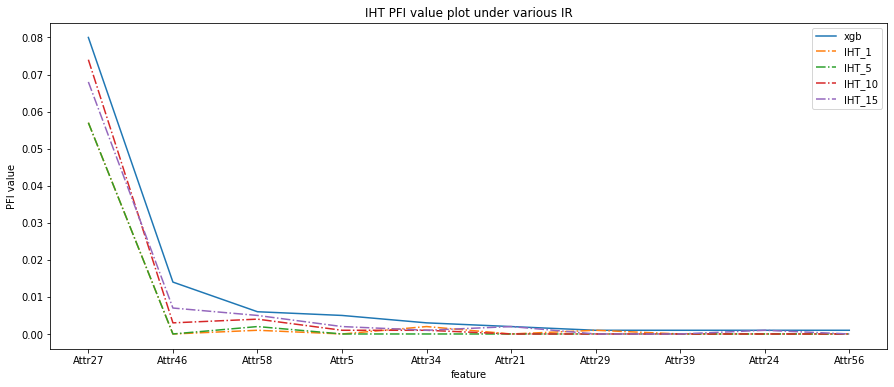

In [95]:
#iht under different IR
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()
iht_1 =pfi_top10['iht1'].tolist()
iht_5 =pfi_top10['iht5'].tolist()
iht_10 =pfi_top10['iht10'].tolist()
iht_15 =pfi_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, iht_1, '-.', label ='IHT_1')
plt.plot(x, iht_5, '-.', label ='IHT_5')
plt.plot(x, iht_10, '-.', label ='IHT_10')
plt.plot(x, iht_15, '-.', label ='IHT_15')

plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('IHT PFI value plot under various IR')
plt.show()


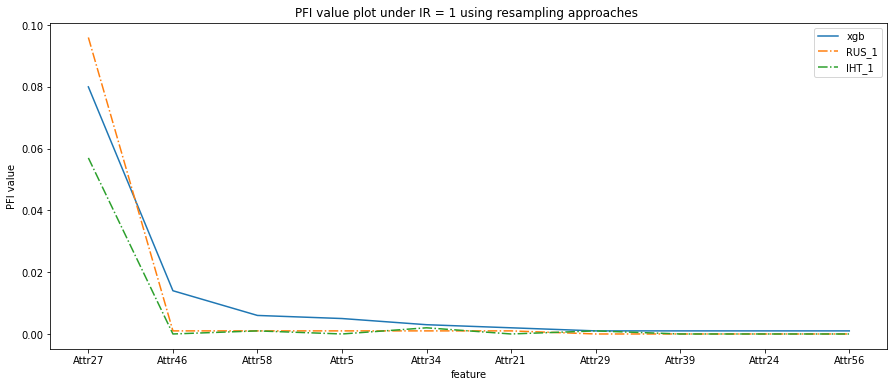

In [96]:
#aggeragate by ratio
#IR=1 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_1 =pfi_top10['rus1'].tolist()
IHT_1 =pfi_top10['iht1'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_1, '-.', label ='RUS_1')
plt.plot(x, IHT_1, '-.', label ='IHT_1')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 1 using resampling approaches ')
plt.show()


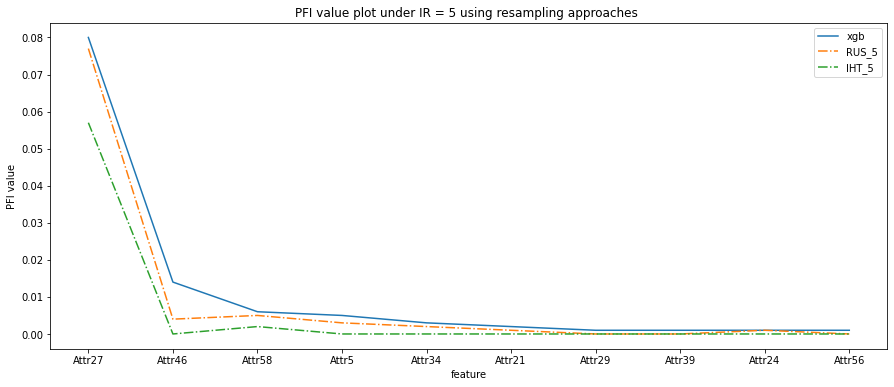

In [97]:
#IR=5 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_5 =pfi_top10['rus5'].tolist()
IHT_5 =pfi_top10['iht5'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_5, '-.', label ='RUS_5')
plt.plot(x, IHT_5, '-.', label ='IHT_5')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 5 using resampling approaches ')
plt.show()


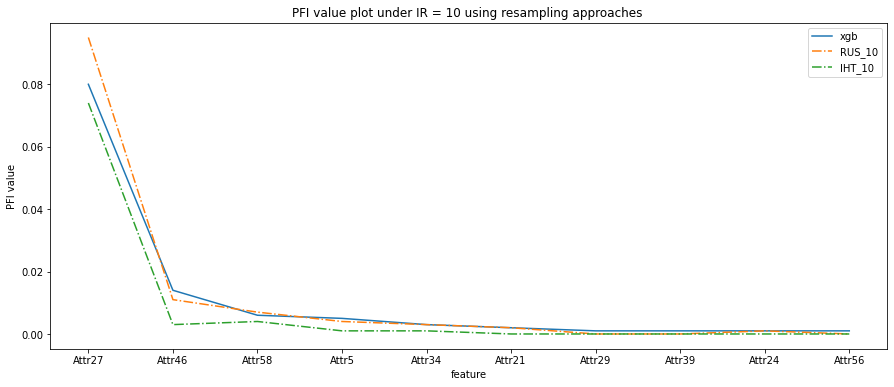

In [98]:
#IR=10 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_10 =pfi_top10['rus10'].tolist()
IHT_10 =pfi_top10['iht10'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_10, '-.', label ='RUS_10')
plt.plot(x, IHT_10, '-.', label ='IHT_10')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 10 using resampling approaches ')
plt.show()


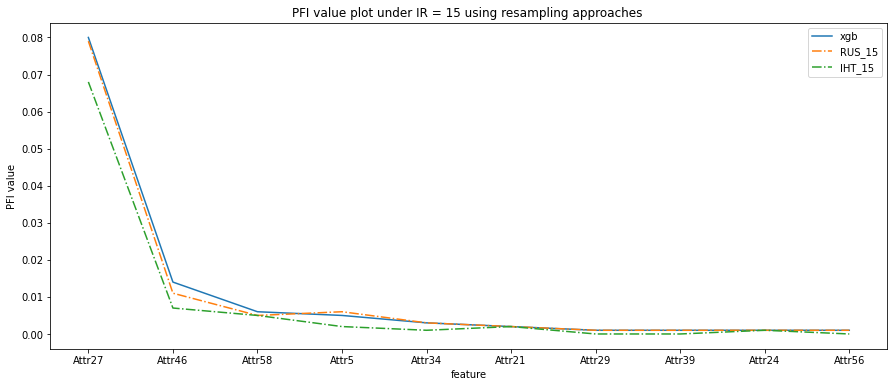

In [99]:
#IR=15 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_15 =pfi_top10['rus15'].tolist()
IHT_15 =pfi_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_15, '-.', label ='RUS_15')
plt.plot(x, IHT_15, '-.', label ='IHT_15')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 15 using resampling approaches ')
plt.show()